In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, MaxPool2D
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import *

In [2]:
len(tf.config.list_physical_devices('GPU'))

1

In [3]:
def import_maps(path):
    images = []
    for index, name in enumerate(os.listdir(path)):
        folder = os.path.join(path, name)
        for file_class in os.listdir(folder):
            if 'patches' in file_class:
                im_folder = os.path.join(folder, file_class)
#                 print(im_folder)
#                 break
                for im in os.listdir(im_folder):
                    img = cv2.imread(os.path.join(im_folder, im))
                    #print(img.shape)
                    if img is not None:
                        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                        img1 = cv2.resize(img, (192, 192))
                        img = np.dstack((img1,img1,img1))
                    if img is not None:
                   #     img = (img-np.mean(img))/np.std(img)
                        images.append((np.array(img), index)) 
    return images

In [4]:
image_train_set = import_maps(r'C:\Users\AIIMS-IITD\Downloads\Meeting_2_9_10\3_cluster_seg\Train')
image_test_set = import_maps(r'C:\Users\AIIMS-IITD\Downloads\Meeting_2_9_10\3_cluster_seg\Test')

In [5]:
train_images_all = [i[0] for i in image_train_set]
train_images_array = np.array(train_images_all)
#train_images_array=np.expand_dims(train_images_array,axis=3)
train_image_label = [i[1] for i in image_train_set]
train_image_label = np.array(train_image_label)

In [6]:
test_images_all = [i[0] for i in image_test_set]
test_images_array = np.array(test_images_all)
#test_images_array=np.expand_dims(test_images_array,axis=3)
test_image_label = [i[1] for i in image_test_set]
test_image_label = np.array(test_image_label)

In [7]:
scalar = StandardScaler(copy=False)
train_images = scalar.fit_transform(train_images_array.reshape(len(train_images_array), 192*192*3))
train_images_array = train_images.reshape(len(train_images_array), 192,192, 3)

In [8]:
test_image = scalar.fit_transform(test_images_array.reshape(len(test_images_array),192*192*3))
test_image_array = test_image.reshape(len(test_images_array),192,192,3)

In [9]:
train_x, val_x, train_y, val_y = train_test_split(train_images_array,train_image_label,test_size=0.2)

In [10]:
enc = OneHotEncoder(handle_unknown='ignore')
train_label_enc = enc.fit_transform(train_image_label.reshape(-1, 1)).toarray()
val_label_enc = enc.fit_transform(val_y.reshape(-1, 1)).toarray()
test_label_enc = enc.fit_transform(test_image_label.reshape(-1, 1)).toarray()

In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2
model = MobileNetV2()

In [ ]:
from keras.layers import Flatten,Dropout,Dense,Activation,Input
from keras.models import Model
from tensorflow.keras import regularizers

new_input = Input(shape=(224, 224, 1))
model1 = MobileNetV2(include_top = False, input_shape=(192,192,3))
layer = model1.get_layer('out_relu').output
x = Flatten()(layer)
x = Dropout(0.5)(x)
x = Dense(128,activation = 'relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.25)(x)
out = Dense(3,activation = 'softmax')(x)
model = Model(model1.input,out)

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,optimizer = keras.optimizers.SGD(0.001),metrics=['accuracy','AUC'])

In [34]:
history = model.fit(train_images_array,train_label_enc,validation_data=(val_x,val_label_enc), batch_size=32, epochs=20, verbose=1,shuffle=True)

Epoch 1/20
239/239 [==============================] - 77s 207ms/step - loss: 1.0334 - accuracy: 0.7442 - auc: 0.8917 - val_loss: 1.0047 - val_accuracy: 0.7397 - val_auc: 0.8906
Epoch 2/20
239/239 [==============================] - 31s 130ms/step - loss: 0.6059 - accuracy: 0.9052 - auc: 0.9829 - val_loss: 0.8332 - val_accuracy: 0.8105 - val_auc: 0.9425
Epoch 3/20
239/239 [==============================] - 30s 124ms/step - loss: 0.4773 - accuracy: 0.9574 - auc: 0.9960 - val_loss: 0.6832 - val_accuracy: 0.8813 - val_auc: 0.9726
Epoch 4/20
239/239 [==============================] - 31s 131ms/step - loss: 0.4243 - accuracy: 0.9793 - auc: 0.9988 - val_loss: 0.5992 - val_accuracy: 0.9115 - val_auc: 0.9840
Epoch 5/20
239/239 [==============================] - 30s 125ms/step - loss: 0.3980 - accuracy: 0.9875 - auc: 0.9997 - val_loss: 0.4780 - val_accuracy: 0.9574 - val_auc: 0.9961
Epoch 6/20
239/239 [==============================] - 29s 122ms/step - loss: 0.3887 - accuracy: 0.9907 - auc: 0.999

In [35]:
score = model.evaluate(test_image_array,test_label_enc, batch_size=32)

35/35 [==============================] - 1s 28ms/step - loss: 2.3308 - accuracy: 0.6667 - auc: 0.8066


In [36]:
y_predict = model.predict(test_image_array)

In [37]:
y_predict_bool = np.argmax(y_predict,axis=1).tolist()

In [38]:
confusion_matrix(test_image_label,y_predict_bool)

array([[204,  36, 129],
       [ 22,   8, 119],
       [ 21,  43, 528]], dtype=int64)

In [39]:
print(classification_report(test_image_label,y_predict_bool))

              precision    recall  f1-score   support

           0       0.83      0.55      0.66       369
           1       0.09      0.05      0.07       149
           2       0.68      0.89      0.77       592

    accuracy                           0.67      1110
   macro avg       0.53      0.50      0.50      1110
weighted avg       0.65      0.67      0.64      1110



In [20]:
503/(19+71+502) *100

84.96621621621621

In [22]:
196/(196+45+128) *100

53.116531165311656

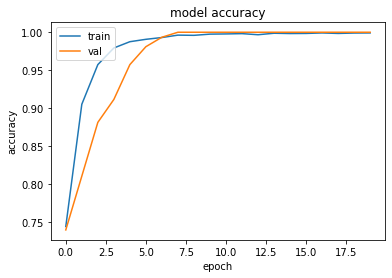

In [40]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

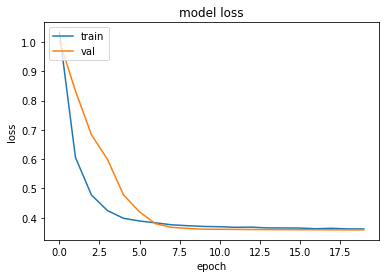

In [41]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

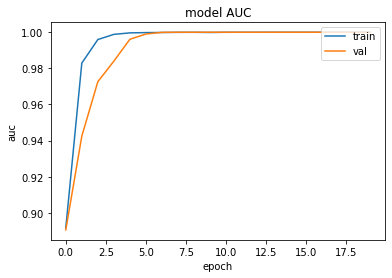

In [43]:
import matplotlib.pyplot as plt
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [11]:
train_images_array.shape

(7623, 192, 192, 3)

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(192,192,3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(4,  activation=tf.nn.softmax)
])

In [13]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 192, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               9

In [ ]:
his = model.fit(train_images_array,train_label_enc, batch_size = 32, epochs = 20, verbose = 1, validation_data = (val_x,val_label_enc))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

